# Predict causal genes for cell state transitions

In this tutorial, we will predict causal genes for cell state transitions using the global cell state manifold and a database of genetic perturbations.

Let's begin by importing the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc

from scmg.model.causal_prediction import CausalGenePredictor

Load the required datasets

In [2]:
adata_ref = sc.read_h5ad('data/ref_global_cell_state_manifold.h5ad')

adata_pert = sc.read_h5ad('data/pseudo_bulk_perturbation_database.h5ad')

# Mask out the direct target genes
for i in range(adata_pert.shape[0]):
    pg = adata_pert.obs['perturbed_gene'].iloc[i]
    
    if pg in adata_pert.var_names:
        adata_pert.X[i, adata_pert.var_names.get_loc(pg)] = 0

As an example, let's consider the transition from epiblast to nascent mesoderm. The cell state transition can be described as a vector of gene expression shifts.

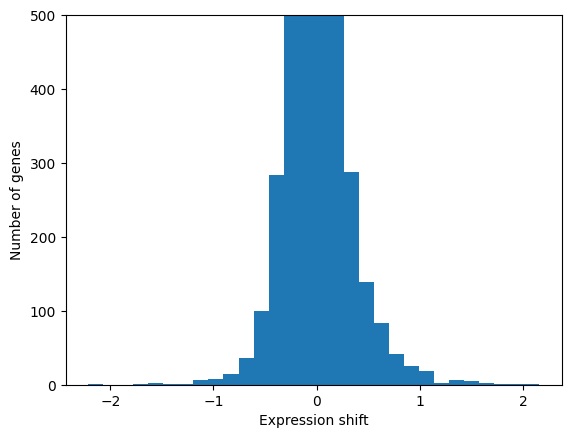

In [3]:
adata = adata_ref[adata_ref.obs['cell_type'].isin(
    ['Epiblast', 'Nascent mesoderm'])].copy()
adata.X = adata.X.toarray()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

source_mean_exp = adata.X[adata.obs['cell_type'] == 'Epiblast'].mean(axis=0)
target_mean_exp = adata.X[adata.obs['cell_type'] == 'Nascent mesoderm'].mean(axis=0)

exp_shift = target_mean_exp - source_mean_exp

# Plot the distribution of expression shifts
plt.hist(exp_shift, bins=30)
plt.xlabel('Expression shift')
plt.ylabel('Number of genes')
plt.ylim(0, 500)
plt.show()

Cell state transitions typically involve expression changes of hundreds to thousands of genes. Some of the genes are causal drivers for a cell state transition, while others are passengers that are dispensible for the transition. In order to predict which genes are causal, we make two assumptions:
1. The expression shift of a causal gene should be large compared to its standard deviation in the global cell state manifold.
2. The perturbation of a causal gene should be able to alter the expression of other genes that change through the cell state transition.

Let's normalize the gene expression shifts by the global cell state manifold and match the expression shifts to the genetic perturbation database.

In [4]:
# Calculate the standard deviation of the genes on the global cell state manifold
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
X_csc = adata_ref.X.tocsc()
adata_ref.var['std'] = [np.std(X_csc.getcol(i).toarray()) for i in range(adata_ref.X.shape[1])]

# Construct a causal gene predictor which will normalize the 
# gene expression shifts and match the shift to perturbations
causal_gene_predictor = CausalGenePredictor(adata_pert, adata_ref.var['std'].values)

# Calculate the match scores
pert_match_df = causal_gene_predictor.calc_causal_scores(exp_shift)
pert_match_df

100%|██████████| 16080/16080 [00:02<00:00, 7757.79it/s]


,condition,perturbed_gene,perturbation_sign,perturbed_gene_name,gene_shift_z,pert_sim,pert_match_score,causal_score
id,,,,,,,,
AdamsonWeissman2016_GSM2406681_10X010_SEC61B_pDS033,AdamsonWeissman2016_GSM2406681_10X010,ENSG00000106803,-1,SEC61B,0.594664,0.003110,-0.003110,-0.001850
AdamsonWeissman2016_GSM2406681_10X010_ASCC3_pDS052,AdamsonWeissman2016_GSM2406681_10X010,ENSG00000112249,-1,ASCC3,-0.281237,0.027262,-0.027262,0.007667
AdamsonWeissman2016_GSM2406681_10X010_DNAJC19_pDS026,AdamsonWeissman2016_GSM2406681_10X010,ENSG00000205981,-1,DNAJC19,0.168256,-0.009787,0.009787,0.001647
AdamsonWeissman2016_GSM2406681_10X010_HSPA9_pDS088,AdamsonWeissman2016_GSM2406681_10X010,ENSG00000113013,-1,HSPA9,-0.323847,-0.018247,0.018247,-0.005909
AdamsonWeissman2016_GSM2406681_10X010_HSPA5_pDS017,AdamsonWeissman2016_GSM2406681_10X010,ENSG00000044574,-1,HSPA5,-0.105252,0.008076,-0.008076,0.000850
...,...,...,...,...,...,...,...,...
TianKampmann2021_CRISPRi_CTSD,TianKampmann2021_CRISPRi,ENSG00000117984,-1,CTSD,-0.169454,0.013613,-0.013613,0.002307
TianKampmann2021_CRISPRi_RNF165,TianKampmann2021_CRISPRi,ENSG00000141622,-1,RNF165,-0.033471,0.003837,-0.003837,0.000128
TianKampmann2021_CRISPRi_NDUFA2,TianKampmann2021_CRISPRi,ENSG00000131495,-1,NDUFA2,0.570147,0.015090,-0.015090,-0.008604


The perturbation of a gene can have different phenotypic effects under different experimental conditions. For causal gene prediction of cell state transition, let's only keep the experimental condition that have the best causal score.

In [5]:
pert_match_df= pert_match_df.sort_values('causal_score', ascending=False)
pert_match_df = pert_match_df.drop_duplicates('perturbed_gene', keep='first')
pert_match_df.sort_values('causal_score', ascending=False)[:20]

,condition,perturbed_gene,perturbation_sign,perturbed_gene_name,gene_shift_z,pert_sim,pert_match_score,causal_score
id,,,,,,,,
hESC_TF_screen_TBXT,hESC_TF_screen,ENSG00000164458,1,TBXT,5.000000,0.198749,0.198749,0.993747
hESC_TF_screen_EOMES,hESC_TF_screen,ENSG00000163508,1,EOMES,2.508312,0.155389,0.155389,0.389764
PertOrg_Pertg00165,PertOrg_Pertg00165,ENSG00000142182,-1,DNMT3L,-4.887468,0.074330,-0.074330,0.363284
PertOrg_Pertg01532,PertOrg_Pertg01532,ENSG00000088305,1,DNMT3B,-2.259588,-0.150434,-0.150434,0.339919
hESC_TF_screen_SNAI1,hESC_TF_screen,ENSG00000124216,1,SNAI1,2.839346,0.107961,0.107961,0.306538
knockTF_human_DataSet_01_45,knockTF_human_DataSet_01_45,ENSG00000147596,-1,PRDM14,-2.788014,0.106656,-0.106656,0.297358
knockTF_human_DataSet_01_42,knockTF_human_DataSet_01_42,ENSG00000204531,-1,POU5F1,-1.897957,0.154678,-0.154678,0.293573
hESC_TF_screen_EVX1,hESC_TF_screen,ENSG00000106038,1,EVX1,2.088400,0.130271,0.130271,0.272057
knockTF_human_DataSet_01_94,knockTF_human_DataSet_01_94,ENSG00000111704,-1,NANOG,-2.193654,0.096152,-0.096152,0.210923


Let's plot the normalized gene expression shifts and the perturbation match scores on a scatter plot. The genes along the diagonal and deviating from the point cloud around the origin are predicted to be causal for the cell state transition. Let's label the gene names of a few strong predictions on the plot.

Text(0, 0.5, 'Perturbation match score')

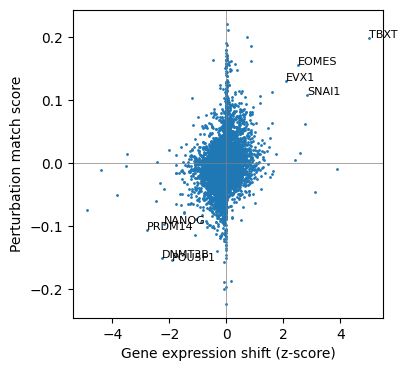

In [6]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.axhline(c='grey', lw=0.5)
ax.axvline(c='grey', lw=0.5)
ax.scatter(pert_match_df['gene_shift_z'], pert_match_df['pert_match_score'], s=1, rasterized=True)

label_df = pert_match_df[pert_match_df['perturbed_gene_name'].isin(
    ['EOMES', 'TBXT', 'EVX1', 'SNAI1', 'POU5F1', 'NANOG', 'PRDM14', 'DNMT3B'])]
for i, row in label_df.iterrows():
    plt.text(row['gene_shift_z'], row['pert_match_score'], row['perturbed_gene_name'], 
             fontsize=8)
    
ax.set_xlabel('Gene expression shift (z-score)')
ax.set_ylabel('Perturbation match score')

Here we can see that the EOMES, TBXT, EVX1 and SNAI1 are predicted to be the positive causal genes for the cell state transition. Indeed, these are transcription factors known to be crucial for primitive streak and mesoderm development. The transcription factors POU5F1 and NANOG, which are responsible for maintaining the pluripotency state, are predicted to be negative causal genes.